# Reframing pipeline


![Alt text](Diagrams/reframe_flowchart.png)

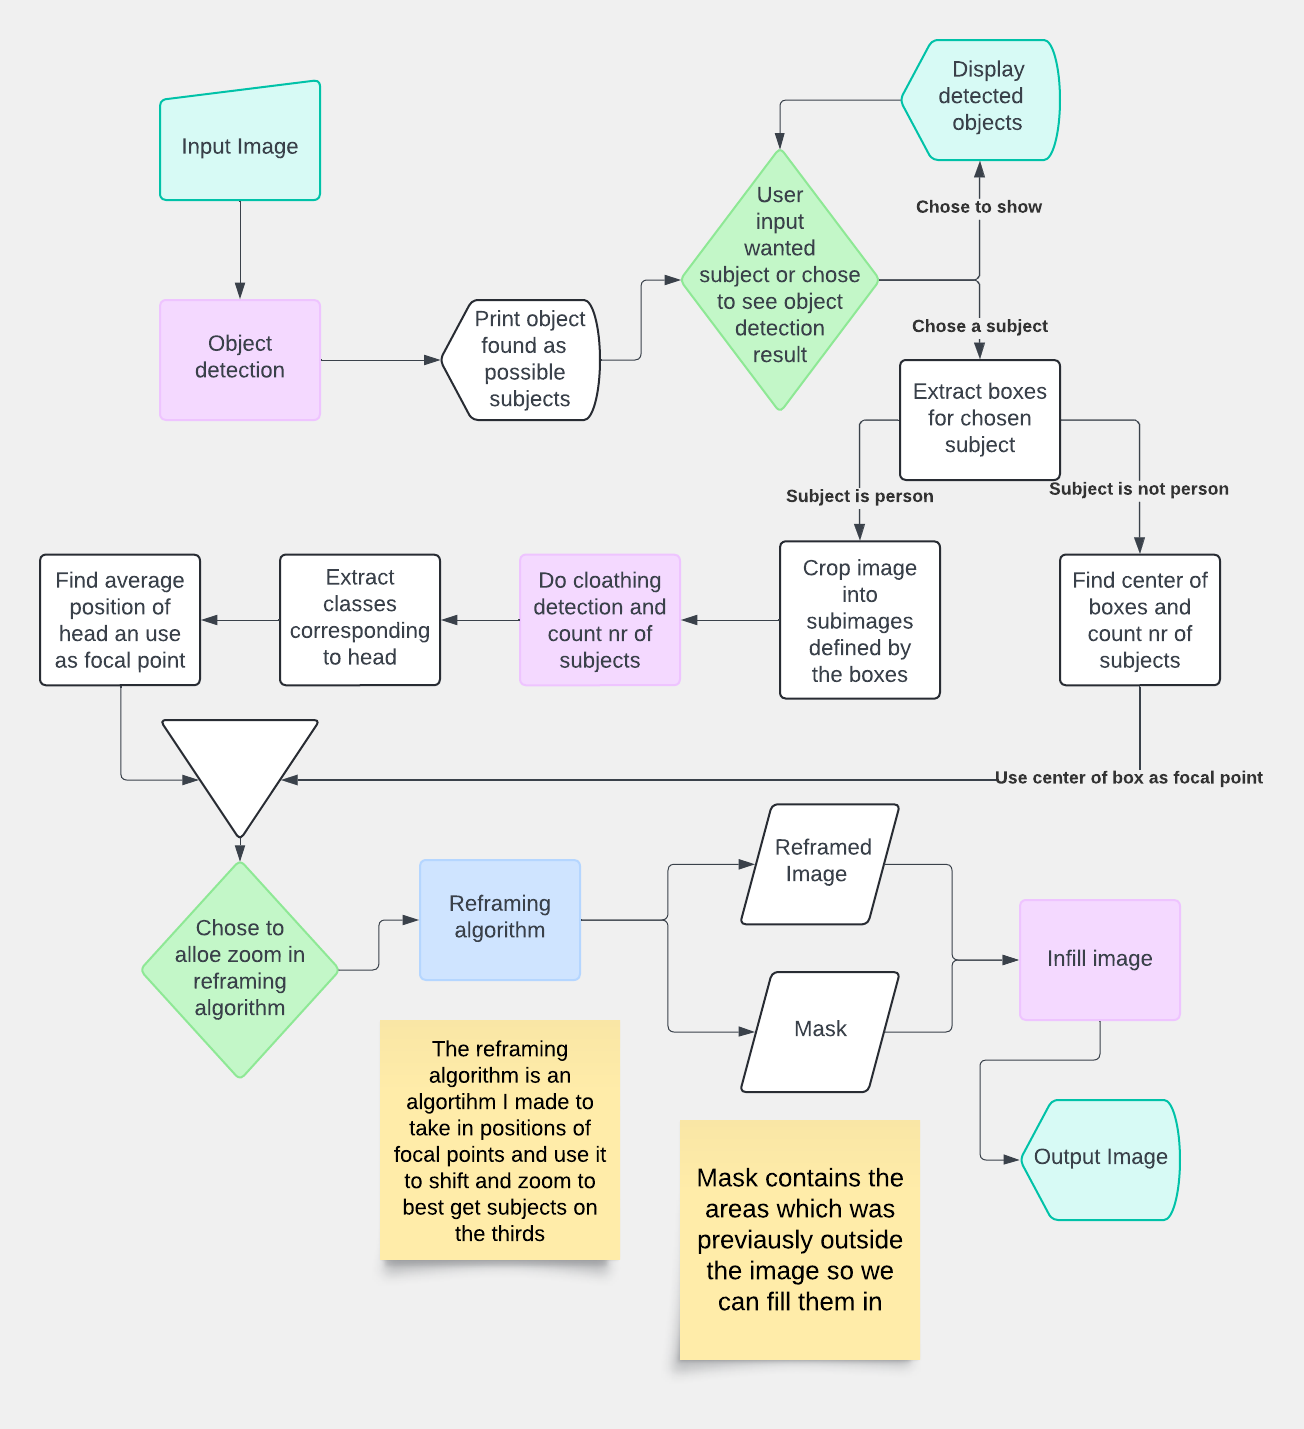

In [1]:
from IPython.display import Image
Image("Diagrams/reframe_flowchart.png")